# Setup

## Easy Install

In [119]:
#Install list of libraries
# %pip install imbalanced-learn
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install scipy
# %pip install seaborn --upgrade
# %pip install graphviz
# %pip install xgboost
# %pip install lightgbm
# %pip install catboost

## Imports and Variables

In [120]:
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, chi2, f_classif, SelectKBest, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from scipy.stats import kendalltau
from scipy.io import loadmat
from os import path, getcwd
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool, cv

# Tree Visualisation
from sklearn.tree import export_graphviz
# from IPython.display import Image
import graphviz

subjects = [102, 104, 105, 107, 110, 111, 115, 116, 117, 118, 120, 126, 127, 130, 131, 132, 133, 135, 138, 141, 143, 144]
col = ['1','2','3','Label', 'Frontal P3 mean', 'Frontal P3 STD', 'Posterior P3 mean', 'Posterior P3 STD', 'Frontal alpha mean', 
           'Posterior alpha mean', 'Alpha variability', 'Reaction time Mean', 'Reaction time variability', 'Accuracy', 'Frontal P3 log energy entropy', 
           'Frontal P3 Shannon entropy', 'Frontal P3 SURE entropy', 'Frontal P3 Skewness', 'Frontal P3 Kurtosis', 'Frontal alpha log energy entropy',
           'Frontal alpha Shannon entropy', 'Frontal alpha SURE entropy', 'Frontal alpha Skewness', 'Frontal alpha Kurtosis', 
           'Posterior P3 log energy entropy', 'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
           'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
           'Posterior alpha Kurtosis'
]
cwd = getcwd()
target_names = ['Task Unrelated Thought', 'Task Related Thought']
results_file = 'Results.xlsx'


Alpha variability and all with posterior features --> see performance,  
Then include behavioural features: 'Reaction time Mean', 'Reaction time variability',and see how it performs

Feature ranking algorithms (top 5, top 10 features)
correlation matrix between features to identify important ** try first

## Data Collection

In [121]:
#Load all subject mat files, append TR and TUR structures to dataframe
for a in subjects:
    file = 'Feature_data_'+str(a)+'.mat'
    #Absolute path to mat file:
    #loc = os.path.join('C:/Users/pisis/OneDrive - University of Calgary/2024/AIRS/TR and TUT data',file)
    loc = path.join(cwd, 'TR and TUT data', file)
    subData = loadmat(loc)['data']
    subData_TR = subData['TR'][0,0]
    subData_TUR = subData['TUR'][0,0]
    subDF_TR = pd.DataFrame(subData_TR, columns = col)
    subDF_TUR = pd.DataFrame(subData_TUR, columns = col)
    if a==subjects[0]:
        totalDF = pd.concat([subDF_TR,subDF_TUR])
    else:
        totalDF = pd.concat([totalDF, subDF_TR])
        totalDF = pd.concat([totalDF, subDF_TUR])

#Show Data with NaN values:
# print(totalDF[totalDF.isnull().any(axis=1)])
# NOTE: Subject 109 has NaN values in the Reaction time Mean and Reaction time variability columns. Excluded from analysis.
# totalDF.fillna(0, inplace=True)

totalDF.reset_index(drop=True, inplace=True)
# print(totalDF)


## Split and Normalize
There are some [different normalization techniques](https://www.geeksforgeeks.org/ml-feature-scaling-part-2/), but all seem to give the same result in our models.

In [122]:
Y = totalDF.Label
Y = Y - 1
all_features = totalDF.iloc[:, 4:]

## Feature Selection
Feature selection is for determining the most important features in our data. We compared all features, the alpha + posterior features, and finally, the alpha + posterior + behavioural features before using the built-in feature analysis (suggested by Sarah).  
[There are many types of feature selection techniques](https://youtu.be/LTE7YbRexl8?si=xW9kJt1lciKEKwAW). 
1. Filter-based techniques:
    - Correlation
    - Variance threshold
    - Chi squared
    - Anova
    - Information Gain
2. Wrapper techniques:
    - Recursive Feature Elimination (RFE)
3. Embed techniques
    - L1 & L2
    - Pruning/Decision trees

In [123]:
ap_columns = ['Posterior P3 mean', 'Posterior P3 STD', 'Posterior alpha mean', 'Alpha variability', 'Accuracy', 'Posterior P3 log energy entropy', 
              'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
              'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
              'Posterior alpha Kurtosis']
ap_features = totalDF[ap_columns]

apb_columns = ['Posterior P3 mean', 'Posterior P3 STD', 'Posterior alpha mean', 'Alpha variability', 'Reaction time Mean', 'Reaction time variability', 'Accuracy',
               'Posterior P3 log energy entropy', 'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
               'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
               'Posterior alpha Kurtosis']
apb_features = totalDF[apb_columns]

### Correlation Matrix Feature Selection

In [124]:
# Correlation Matrix:
corrMat = all_features.corr()
plt.figure(figsize=(20,20))
# sns.heatmap(corrMat, annot=True, cmap='Blues', fmt=".2f")

# All features with correlation ge than .80:
columns_to_drop = ['Frontal P3 log energy entropy','Frontal alpha log energy entropy', 'Frontal alpha Kurtosis', 
                   'Posterior P3 log energy entropy', 'Posterior alpha log energy entropy', 'Posterior alpha Kurtosis']
uncorr_features = all_features.drop(columns=columns_to_drop, axis=1)
# sns.heatmap(uncorr_features.corr(), annot=True, cmap='Blues', fmt=".2f")

<Figure size 2000x2000 with 0 Axes>

### Kendall's Tau Correlation Matrix

In [125]:
kenmat = all_features.corr(method='kendall')
# sns.heatmap(kenmat, annot=True, cmap='Blues', fmt=".2f")

# All features with kendall correlation greater than .80
columns_to_drop = ['Frontal P3 log energy entropy', 'Posterior P3 log energy entropy']
kendall_features = all_features.drop(columns=columns_to_drop, axis=1)

### Variance Threshold

In [126]:
vt = VarianceThreshold(threshold=0.1)
vt.fit(all_features)
mask = vt.get_support()
print("Features excluded: ", all_features.columns[~mask].values)
vt_features = all_features.loc[:, mask]

Features excluded:  ['Accuracy' 'Frontal P3 Kurtosis' 'Frontal alpha Skewness'
 'Posterior P3 Skewness' 'Posterior P3 Kurtosis']


### SelectKBest - ANOVA

In [127]:
test = SelectKBest(score_func=f_classif, k=10)
fit = test.fit(all_features, Y)
mask = fit.get_support()
print("Features excluded: ", all_features.columns[~mask].values)
anova_features = all_features.loc[:, mask]

Features excluded:  []


### Final Feature Selection

In [128]:
# 'AP' = alpha + posterior, 'APB' = alpha + posterior + behvaioural, 'all' = all features
Select_features = 'uncorr'
Notes = ''

if Select_features == 'AP':
    X = ap_features
elif Select_features == 'APB':
    X = apb_features
elif Select_features == 'uncorr':
    X = uncorr_features
elif Select_features == 'vt':
    X = vt_features
elif Select_features == 'ANOVA':
    X = anova_features
elif Select_features == 'kendalls':
    X = kendall_features
else: 
    X = all_features
    

scale = 3
if scale == 1:
    scaler = StandardScaler()
elif scale == 2:
    scaler = MinMaxScaler()
elif scale == 3:
    scaler = Normalizer()
else:
    scaler = None
    
# print(X.columns)
# Verify that Labels contain only 0 and 1:
# print(X.Label.unique())

# Model Selection

## Variables init
Choose what type of KFold, which measures you would like, what info you would like to store in results. Some resources:
- [svm](https://www.youtube.com/watch?v=efR1C6CvhmE)
- [Gradient Boosting info](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)

In [148]:
def tp(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)[0, 0] # True Positives
def tn(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)[1, 1] # True Negatives
def fp(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)[0, 1] # False Positives
def fn(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)[1, 0] # False Negatives

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
index = []
scores = {"Accuracy": [], "BA": [], "Matt_Corr_Coef": [], "tp": [], "tn": [], "fp": [], "fn": [], "AUC": []}
results = {'Timestamp': [], 'Features': [], 'Normalized': [], 'CrossVal': type(kf).__name__, 'model': [], "Accuracy": [], 
           "BA": [], "Matt_Corr_Coef": [], 'AUC': [], 'tp': [], 'tn': [], 'fp': [], 'fn': [], 'Notes': Notes}
scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'balanced_accuracy': metrics.make_scorer(metrics.balanced_accuracy_score),
    'matthews_corrcoef': metrics.make_scorer(metrics.matthews_corrcoef),
    'AUC': metrics.make_scorer(metrics.roc_auc_score),
    'tp': metrics.make_scorer(tp),
    'tn': metrics.make_scorer(tn),
    'fp': metrics.make_scorer(fp),
    'fn': metrics.make_scorer(fn)
}
# Fill this with the models you would like to test:
regressors = [LogisticRegression(max_iter=1800, random_state=42), RandomForestClassifier(random_state=42), GradientBoostingClassifier(random_state=42, verbose = False), SVC(random_state=42), KNeighborsClassifier(), 
              XGBClassifier(random_state=42), LGBMClassifier(random_state=42), CatBoostClassifier(random_state=42, verbose = False)]
# regressors = [CatBoostClassifier(depth= 6, iterations= 300, learning_rate= 0.1, random_state=42, verbose=False), 
#               RandomForestClassifier(bootstrap= False, max_depth= 29, max_features= "log2", min_samples_leaf= 1, 
#                                      min_samples_split= 2, n_estimators= 200, random_state=42),]
# regressors = [RandomForestClassifier(random_state=42)]

Complex nested loops. More information on the structure of this pipeline and SMOTE [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [149]:
for feature in ['AP', 'APB', 'uncorr', 'vt', 'ANOVA', 'kendalls', 'all']:
    if feature == 'AP':
        X = ap_features 
    elif feature == 'APB':
        X = apb_features
    elif feature == 'uncorr':
        X = uncorr_features
    elif feature == 'vt':
        X = vt_features
    elif feature == 'ANOVA':
        X = anova_features
    elif feature == 'kendalls':
        X = kendall_features
    else: 
        X = all_features
        
    # for scaler in [None, StandardScaler(), MinMaxScaler(), Normalizer()]:
    for scaler in [None, Normalizer()]:
        for regressor in regressors:
            for train_index, test_index in kf.split(X, Y):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
                
                oversample = SMOTE(random_state=42)
                undersample = RandomUnderSampler(random_state=42)
                pipe = Pipeline([('smt', oversample), ('under', undersample), ('normalizer', scaler), ('classifier', regressor)])
                cv_results = cross_validate(pipe, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True)
                scores["Accuracy"].append(cv_results['test_accuracy'].mean())
                scores["BA"].append(cv_results['test_balanced_accuracy'].mean())
                scores["Matt_Corr_Coef"].append(cv_results['test_matthews_corrcoef'].mean())
                scores["AUC"].append(cv_results['test_AUC'].mean())
                scores["tp"].append(cv_results['test_tp'].mean())
                scores["tn"].append(cv_results['test_tn'].mean())
                scores["fp"].append(cv_results['test_fp'].mean())
                scores["fn"].append(cv_results['test_fn'].mean())
            
            print('\n')
            print(type(regressor).__name__)
            results['model'].append(type(regressor).__name__)
            
            for key in scores:
                print(key, ":", np.mean(scores[key]))
                results[key].append(np.mean(scores[key]))
            print("\n")    
            results['Timestamp'].append(pd.Timestamp.now())
            results['Normalized'].append(scaler.__class__.__name__ if scaler else 'None')
            results["Features"].append(feature)
            
            scores = {"Accuracy": [], "BA": [], "Matt_Corr_Coef": [], "tp": [], "tn": [], "fp": [], "fn": [], "AUC": []}
        



LogisticRegression
Accuracy : 0.43999735589635114
BA : 0.48653646277351514
Matt_Corr_Coef : -0.023129912947872377
tp : 9.34
tn : 17.869999999999997
fp : 6.68
fn : 27.939999999999998
AUC : 0.48653646277351514




RandomForestClassifier
Accuracy : 0.6134452670544686
BA : 0.4924642298948565
Matt_Corr_Coef : -0.015257302508861611
tp : 3.8699999999999997
tn : 34.06
fp : 12.15
fn : 11.75
AUC : 0.4924642298948565




GradientBoostingClassifier
Accuracy : 0.5650713907985193
BA : 0.49218996874111964
Matt_Corr_Coef : -0.014769006182303337
tp : 5.460000000000001
tn : 29.48
fp : 10.559999999999999
fn : 16.33
AUC : 0.49218996874111964




SVC
Accuracy : 0.30667636171337914
BA : 0.501384963768116
Matt_Corr_Coef : 0.008156536559982538
tp : 14.510000000000002
tn : 4.450000000000001
fp : 1.5100000000000002
fn : 41.36
AUC : 0.501384963768116




KNeighborsClassifier
Accuracy : 0.5412665256478053
BA : 0.5104183361750498
Matt_Corr_Coef : 0.018658701632996523
tp : 7.15
tn : 26.32
fp : 8.870000000000001
f

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.5906240084611316
BA : 0.4718369387610116
Matt_Corr_Coef : -0.0565742455394832
tp : 3.6100000000000003
tn : 32.91
fp : 12.41
fn : 12.9
AUC : 0.47183693876101174


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6025912215758857
BA : 0.49675941318556405
Matt_Corr_Coef : -0.006330925614790007
tp : 4.4399999999999995
tn : 32.82
fp : 11.580000000000002
fn : 12.99
AUC : 0.49675941318556405


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6036858804865151
BA : 0.48614641943734005
Matt_Corr_Coef : -0.028783816369108373
tp : 3.88
tn : 33.45
fp : 12.139999999999999
fn : 12.36
AUC : 0.48614641943734016


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_na

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6106821787414066
BA : 0.5001875532821825
Matt_Corr_Coef : -0.000564306575807242
tp : 4.34
tn : 33.42
fp : 11.68
fn : 12.39
AUC : 0.5001875532821825


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:08:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:08:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6290269698572184
BA : 0.5037091503267974
Matt_Corr_Coef : 0.005958556055478438
tp : 3.9
tn : 34.99
fp : 12.120000000000001
fn : 10.819999999999999
AUC : 0.5037091503267974


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6325066102591222
BA : 0.5161495098039215
Matt_Corr_Coef : 0.033687896934676144
tp : 4.4
tn : 34.71
fp : 11.620000000000001
fn : 11.1
AUC : 0.5161495098039215


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

c:\Users\pisis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\pisis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_



LogisticRegression
Accuracy : 0.4959280803807509
BA : 0.5113055200341006
Matt_Corr_Coef : 0.020253576605770644
tp : 8.7
tn : 21.96
fp : 7.32
fn : 23.85
AUC : 0.5113055200341006




RandomForestClassifier
Accuracy : 0.6555631940772079
BA : 0.5197081202046037
Matt_Corr_Coef : 0.04271447096548544
tp : 3.81
tn : 36.71999999999999
fp : 12.209999999999999
fn : 9.09
AUC : 0.5197081202046037




GradientBoostingClassifier
Accuracy : 0.5889159175039661
BA : 0.5076456557260586
Matt_Corr_Coef : 0.014343981150292045
tp : 5.43
tn : 30.98
fp : 10.59
fn : 14.830000000000002
AUC : 0.5076456557260586




SVC
Accuracy : 0.314672131147541
BA : 0.5038819444444445
Matt_Corr_Coef : 0.020607311641494097
tp : 14.37
tn : 5.090000000000001
fp : 1.65
fn : 40.72
AUC : 0.5038819444444445




KNeighborsClassifier
Accuracy : 0.5040031729243787
BA : 0.4790531578573457
Matt_Corr_Coef : -0.037161617746604224
tp : 6.840000000000001
tn : 24.32
fp : 9.18
fn : 21.490000000000002
AUC : 0.4790531578573457




c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6207509254362771
BA : 0.5066524580846832
Matt_Corr_Coef : 0.013720519591270134
tp : 4.32
tn : 34.06
fp : 11.7
fn : 11.75
AUC : 0.5066524580846832


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6232469592808039
BA : 0.5062723607558965
Matt_Corr_Coef : 0.012201064336036354
tp : 4.220000000000001
tn : 34.32
fp : 11.8
fn : 11.489999999999998
AUC : 0.5062723607558965


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\Users\pisis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\pisis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_



LogisticRegression
Accuracy : 0.4962453728186145
BA : 0.5121319089229894
Matt_Corr_Coef : 0.021519851248742557
tp : 8.73
tn : 21.950000000000003
fp : 7.289999999999999
fn : 23.860000000000003
AUC : 0.5121319089229894




RandomForestClassifier
Accuracy : 0.6521734531993655
BA : 0.5107792696788861
Matt_Corr_Coef : 0.023254307143036817
tp : 3.4800000000000004
tn : 36.839999999999996
fp : 12.540000000000001
fn : 8.97
AUC : 0.5107792696788861




GradientBoostingClassifier
Accuracy : 0.5927128503437334
BA : 0.49971408780903664
Matt_Corr_Coef : 0.00021409367349478834
tp : 4.909999999999999
tn : 31.73
fp : 11.110000000000001
fn : 14.080000000000002
AUC : 0.49971408780903664




SVC
Accuracy : 0.31451084082496034
BA : 0.5035694444444444
Matt_Corr_Coef : 0.020063905001540823
tp : 14.36
tn : 5.090000000000001
fp : 1.6600000000000001
fn : 40.72
AUC : 0.5035694444444444




KNeighborsClassifier
Accuracy : 0.5040031729243787
BA : 0.4790531578573457
Matt_Corr_Coef : -0.037161617746604224
tp : 6.8

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6190190375462719
BA : 0.4959437517760727
Matt_Corr_Coef : -0.0065989852378675095
tp : 3.85
tn : 34.419999999999995
fp : 12.17
fn : 11.389999999999999
AUC : 0.4959437517760727


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6383447911158118
BA : 0.5154369138959932
Matt_Corr_Coef : 0.03150505749932066
tp : 4.17
tn : 35.3
fp : 11.850000000000001
fn : 10.51
AUC : 0.5154369138959932


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6224299312533051
BA : 0.4960367114237
Matt_Corr_Coef : -0.007646270755961783
tp : 3.7399999999999998
tn : 34.74
fp : 12.28
fn : 11.07
AUC : 0.4960367114237


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6345928080380752
BA : 0.5141147875816994
Matt_Corr_Coef : 0.02910540584116651
tp : 4.23
tn : 35.010000000000005
fp : 11.790000000000003
fn : 10.799999999999999
AUC : 0.5141147875816995


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

c:\Users\pisis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\pisis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_



LogisticRegression
Accuracy : 0.4962453728186145
BA : 0.5121319089229894
Matt_Corr_Coef : 0.021519851248742557
tp : 8.73
tn : 21.950000000000003
fp : 7.289999999999999
fn : 23.860000000000003
AUC : 0.5121319089229894




RandomForestClassifier
Accuracy : 0.6521734531993655
BA : 0.5107792696788861
Matt_Corr_Coef : 0.023254307143036817
tp : 3.4800000000000004
tn : 36.839999999999996
fp : 12.540000000000001
fn : 8.97
AUC : 0.5107792696788861




GradientBoostingClassifier
Accuracy : 0.5927128503437334
BA : 0.49971408780903664
Matt_Corr_Coef : 0.00021409367349478834
tp : 4.909999999999999
tn : 31.73
fp : 11.110000000000001
fn : 14.080000000000002
AUC : 0.49971408780903664




SVC
Accuracy : 0.31451084082496034
BA : 0.5035694444444444
Matt_Corr_Coef : 0.020063905001540823
tp : 14.36
tn : 5.090000000000001
fp : 1.6600000000000001
fn : 40.72
AUC : 0.5035694444444444




KNeighborsClassifier
Accuracy : 0.5040031729243787
BA : 0.4790531578573457
Matt_Corr_Coef : -0.037161617746604224
tp : 6.8

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6190190375462719
BA : 0.4959437517760727
Matt_Corr_Coef : -0.0065989852378675095
tp : 3.85
tn : 34.419999999999995
fp : 12.17
fn : 11.389999999999999
AUC : 0.4959437517760727


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\pisis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarni



XGBClassifier
Accuracy : 0.6383447911158118
BA : 0.5154369138959932
Matt_Corr_Coef : 0.03150505749932066
tp : 4.17
tn : 35.3
fp : 11.850000000000001
fn : 10.51
AUC : 0.5154369138959932


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
# print(cv_results.keys())

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_matthews_corrcoef', 'train_matthews_corrcoef', 'test_AUC', 'train_AUC', 'test_tp', 'train_tp', 'test_tn', 'train_tn', 'test_fp', 'train_fp', 'test_fn', 'train_fn'])


In [ ]:
# print(cv_results.keys())
# train_scores = cv_results['train_balanced accuracy']
# test_scores = cv_results['test_balanced accuracy']
# print("Model: ", pipe.named_steps['classifier'])
# print("Train Scores: ", train_scores)
# print("Test Scores: ", test_scores)

Model:  RandomForestClassifier(random_state=42)
Train Scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test Scores:  [0.53431373 0.5        0.52777778 0.56045752 0.51470588 0.59640523
 0.45915033 0.53333333 0.42156863 0.49019608]


## Record Results
Add these Results and Test Conditions to Results.xlsx. Will delete duplicate results within conditions.

In [152]:
df_newScores = pd.DataFrame(results)
print(df_newScores)
df_existingRecord = pd.read_excel(results_file)
df_combined = pd.concat([df_existingRecord, df_newScores], ignore_index=True)
df_combined.drop_duplicates(subset=['Features', 'model', "Accuracy", "BA", "Matt_Corr_Coef", 'AUC', 'tp', 'fp', 'fn', 'tn', 'Notes'], keep='last', inplace = True)
df_combined.sort_values(by='Matt_Corr_Coef', ascending=False, inplace=True)
df_combined.to_excel(results_file, index=False)

                     Timestamp Features  Normalized         CrossVal  \
0   2024-06-04 01:37:26.107915       AP        None  StratifiedKFold   
1   2024-06-04 01:38:02.008799       AP        None  StratifiedKFold   
2   2024-06-04 01:38:53.149824       AP        None  StratifiedKFold   
3   2024-06-04 01:39:02.642435       AP        None  StratifiedKFold   
4   2024-06-04 01:39:07.775706       AP        None  StratifiedKFold   
..                         ...      ...         ...              ...   
107 2024-06-04 03:38:40.653841      all  Normalizer  StratifiedKFold   
108 2024-06-04 03:38:52.128151      all  Normalizer  StratifiedKFold   
109 2024-06-04 03:39:08.854934      all  Normalizer  StratifiedKFold   
110 2024-06-04 03:39:25.761744      all  Normalizer  StratifiedKFold   
111 2024-06-04 03:47:06.952396      all  Normalizer  StratifiedKFold   

                          model  Accuracy        BA  Matt_Corr_Coef       AUC  \
0            LogisticRegression  0.439997  0.486536   

In [ ]:
def scatter_plot(X_train, y_train):
    colors_palette = {0: 'green', 1: 'red'}
    colors = [colors_palette[c] for c in y_train]
    grr = pd.plotting.scatter_matrix(X_train, c=colors, marker=".", figsize =(20,15), alpha = 0.8, range_padding=0.05, diagonal="kde" , s=60, grid=True)
#     plt.savefig("scatter_kaggle_normalized(5 attr).png")

# Tuning Hyperparameters

In [ ]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()

## Random Forest Classifier

In [84]:
# randfor_param_grid = {
#     'classifier__n_estimators': [25, 50, 75, 100, 125, 150],
#     'classifier__max_depth': [15, 17, 19, 21, 23, 25],
#     'classifier__min_samples_split': [2, 3, 4],
#     'classifier__min_samples_leaf': [1, 2, 3, 4],
#     'classifier__max_features': ['log2', 'auto'],
#     'classifier__bootstrap': [False, True]
# }
param_grid = {
    'classifier__n_estimators': [25, 50],
    'classifier__max_depth': [15, 17],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['log2'],
    'classifier__bootstrap': [False]
}
pipe = Pipeline([('smt', SMOTE(random_state=42)), ('normalizer', Normalizer()), ('classifier', RandomForestClassifier(random_state=42))])
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(estimator=pipe, 
                                param_grid=param_grid, cv=kf, verbose=2,
                                n_jobs=-1, scoring='balanced_accuracy')

In [85]:
for k, (train_index, test_index) in enumerate(kf.split(X, Y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    random_search.fit(X_train, y_train)
    print(f'Fold ', k+1)
    print(random_search.best_params_)
    print(f'Train Accuracy: {random_search.best_score_}')
    print(f'Test Accuracy: {random_search.score(X_test, y_test)}')

    
# random_search.fit(X, Y)
# print(random_search.best_params_)


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fold  1
{'classifier__bootstrap': False, 'classifier__max_depth': 15, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25}
Train Accuracy: 0.521881038647343
Test Accuracy: 0.5898692810457516
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fold  2
{'classifier__bootstrap': False, 'classifier__max_depth': 17, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25}
Train Accuracy: 0.5207608695652175
Test Accuracy: 0.5669934640522876
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fold  3
{'classifier__bootstrap': False, 'classifier__max_depth': 15, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25}
Train Accuracy: 0.5321497584541064
Test Accuracy: 0.4

In [80]:
print(random_search)
print(f'Train Accuracy: {random_search.best_score_}')
print(f'Test Accuracy: {random_search.score(X, Y)}')

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                       ('normalizer', Normalizer()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [False, True],
                         'classifier__max_depth': [15, 17, 19, 21, 23, 25],
                         'classifier__max_features': ['log2', 'auto'],
                         'classifier__min_samples_leaf': [1, 2, 3, 4],
                         'classifier__min_samples_split': [2, 3, 4],
                         'classifier__n_estimators': [25, 50, 75, 100, 125,
                                                      150]},
             scoring='balanced_accuracy', verbose=2)
Train Accuracy: 0.5413071895424837
Test Accuracy: 0.9632072139687866


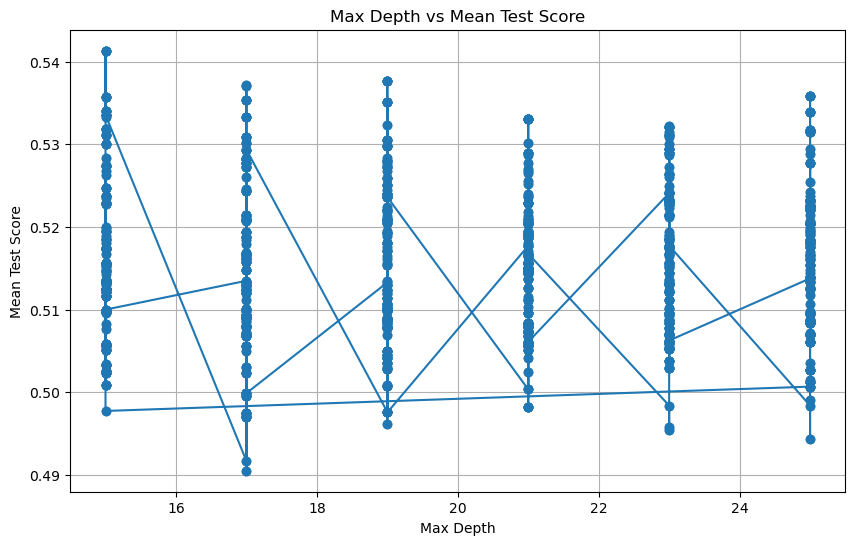

In [56]:
results = random_search.cv_results_

# Get the mean test scores (averaged over all folds)
mean_test_scores = results['mean_test_score']

# Get the max_depth parameters
max_depths = results['param_classifier__max_depth']

# Plot max_depth vs mean_test_score
plt.figure(figsize=(10, 6))
plt.plot(max_depths, mean_test_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score')
plt.title('Max Depth vs Mean Test Score')
plt.grid(True)
plt.show()

## Random Search Training

## CatBoost
[Hyperparameter tutorial](https://www.geeksforgeeks.org/catboost-parameters-and-hyperparameters/)

In [21]:
X = uncorr_features
catboost_pool = Pool(X, label = Y)
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'MultiClass',
    'verbose': 200,
    'random_state': 42
}
cv_results, cv_model = cv(catboost_pool, params, fold_count=5, plot=True, verbose=200, return_models=True, stratified=True)
available_metrics = [metric for metric in cv_results.columns if 'test' in metric]
print(available_metrics)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.6711841	test: 0.6768894	best: 0.6768894 (0)	total: 126ms	remaining: 2m 6s
200:	learn: 0.1565821	test: 0.5862259	best: 0.5624659 (46)	total: 1.38s	remaining: 5.48s
400:	learn: 0.0662619	test: 0.6314215	best: 0.5624659 (46)	total: 2.4s	remaining: 3.58s
600:	learn: 0.0365652	test: 0.6773662	best: 0.5624659 (46)	total: 3.04s	remaining: 2.02s
800:	learn: 0.0240501	test: 0.7168340	best: 0.5624659 (46)	total: 3.7s	remaining: 919ms
999:	learn: 0.0175629	test: 0.7446482	best: 0.5624659 (46)	total: 4.44s	remaining: 0us

bestTest = 0.5624658572
bestIteration = 46

Training on fold [1/5]
0:	learn: 0.6731328	test: 0.6774387	best: 0.6774387 (0)	total: 3.92ms	remaining: 3.91s
200:	learn: 0.1569696	test: 0.5961190	best: 0.5679273 (57)	total: 1.01s	remaining: 4.02s
400:	learn: 0.0664939	test: 0.6339287	best: 0.5679273 (57)	total: 1.81s	remaining: 2.7s
600:	learn: 0.0376481	test: 0.6703753	best: 0.5679273 (57)	total: 2.47s	remaining: 1.64s
800:	learn: 0.0246776	test: 0

In [ ]:
# Define the parameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8]
}

# Create the CatBoostClassifier
model = CatBoostClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new CatBoostClassifier with the best parameters
# best_model = CatBoostClassifier(**best_params)

In [26]:
print(best_params)
print(best_score)

{'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
0.8281781672143118
